In [1]:
# Check GPU
import torch
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi


CUDA available: True
Fri Nov 21 00:37:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   39C    P0             56W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------------

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/

!pip install torch torchvision pycocotools pillow pandas tqdm matplotlib seaborn albumentations==1.4.0


/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [5]:
!unzip "/content/drive/MyDrive/ML_datasets/StanfordDogs.zip" -d /content/dogs/


Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1560.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_15702.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1571.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1575.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1619.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1626.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1654.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1672.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1675.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1690.jpg  
  inflating: /content/dogs/StanfordDogs/Images/n02108089-boxer/n02108089_1748.jpg  
  inflating: /content/do

In [6]:
!ls /content/dogs/StanfordDogs/Images/
!ls /content/dogs/StanfordDogs/Annotation/

n02085620-Chihuahua			  n02100583-vizsla
n02085782-Japanese_spaniel		  n02100735-English_setter
n02085936-Maltese_dog			  n02100877-Irish_setter
n02086079-Pekinese			  n02101006-Gordon_setter
n02086240-Shih-Tzu			  n02101388-Brittany_spaniel
n02086646-Blenheim_spaniel		  n02101556-clumber
n02086910-papillon			  n02102040-English_springer
n02087046-toy_terrier			  n02102177-Welsh_springer_spaniel
n02087394-Rhodesian_ridgeback		  n02102318-cocker_spaniel
n02088094-Afghan_hound			  n02102480-Sussex_spaniel
n02088238-basset			  n02102973-Irish_water_spaniel
n02088364-beagle			  n02104029-kuvasz
n02088466-bloodhound			  n02104365-schipperke
n02088632-bluetick			  n02105056-groenendael
n02089078-black-and-tan_coonhound	  n02105162-malinois
n02089867-Walker_hound			  n02105251-briard
n02089973-English_foxhound		  n02105412-kelpie
n02090379-redbone			  n02105505-komondor
n02090622-borzoi			  n02105641-Old_English_sheepdog
n02090721-Irish_wolfhound		  n02105855-Shetland_sheepdog
n02091032-Itali

In [7]:
# --- WRITE ALL SCRIPTS ---

scripts = {

# -----------------------------------------------------------
# 1) convert_to_coco.py  (your final, png+jpg aware version)
# -----------------------------------------------------------
"convert_to_coco.py": r'''
import os, json, xml.etree.ElementTree as ET
from tqdm import tqdm

def convert(images_dir, annot_dir, out_json):
    breeds = sorted([d for d in os.listdir(annot_dir) if os.path.isdir(os.path.join(annot_dir, d))])
    categories = [{"id": i + 1, "name": b} for i, b in enumerate(breeds)]
    breed_to_id = {b: i + 1 for i, b in enumerate(breeds)}

    coco = {"images": [], "annotations": [], "categories": categories}
    ann_id = 1; img_id = 1

    for breed in tqdm(breeds, desc="Breeds"):
        ann_folder = os.path.join(annot_dir, breed)
        img_folder = os.path.join(images_dir, breed)

        for xml_file in sorted(os.listdir(ann_folder)):
            xml_path = os.path.join(ann_folder, xml_file)
            if not os.path.isfile(xml_path):
                continue

            root = ET.parse(xml_path).getroot()

            filename_node = root.find("filename")
            filename = filename_node.text if filename_node is not None else xml_file.replace(".xml","")

            # support both jpg and png
            img_path = None
            for ext in [".jpg",".jpeg",".png"]:
                test = os.path.join(img_folder, filename.replace(".xml","") + ext)
                if os.path.exists(test):
                    img_path = test
                    filename = os.path.basename(test)
                    break

            if img_path is None:
                print(f"Missing image for {xml_file}")
                continue

            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            coco["images"].append({
                "id": img_id,
                "file_name": f"{breed}/{filename}",
                "width": width, "height": height
            })

            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                xmin = int(float(bbox.find("xmin").text))
                ymin = int(float(bbox.find("ymin").text))
                xmax = int(float(bbox.find("xmax").text))
                ymax = int(float(bbox.find("ymax").text))
                w, h = xmax - xmin, ymax - ymin

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "bbox": [xmin, ymin, w, h],
                    "category_id": breed_to_id[breed],
                    "iscrowd": 0,
                    "area": w * h
                })
                ann_id += 1

            img_id += 1

    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(coco, f, indent=2)

    print("Saved COCO ->", out_json)
    print("Images:", len(coco["images"]), "Annotations:", len(coco["annotations"]))

if __name__ == "__main__":
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--images_dir")
    ap.add_argument("--annot_dir")
    ap.add_argument("--out_json")
    args = ap.parse_args()
    convert(args.images_dir, args.annot_dir, args.out_json)
''',

# -----------------------------------------------------------
# 2) split_train_val.py
# -----------------------------------------------------------
"split_train_val.py": r'''
import json, random, os

def split(json_in, train_out, val_out, ratio=0.9):
    with open(json_in,"r",encoding="utf-8") as f:
        coco=json.load(f)
    ids=[im["id"] for im in coco["images"]]
    random.shuffle(ids)
    cut=int(len(ids)*ratio)
    train_ids=set(ids[:cut])
    val_ids=set(ids[cut:])

    def subset(sel):
        return {
            "images":[im for im in coco["images"] if im["id"] in sel],
            "annotations":[a for a in coco["annotations"] if a["image_id"] in sel],
            "categories": coco["categories"]
        }

    os.makedirs(os.path.dirname(train_out),exist_ok=True)
    with open(train_out,"w") as f: json.dump(subset(train_ids),f)
    with open(val_out,"w") as f: json.dump(subset(val_ids),f)
    print("Train:",len(train_ids),"Val:",len(val_ids))

if __name__ == "__main__":
    import argparse
    ap=argparse.ArgumentParser()
    ap.add_argument("--json_in")
    ap.add_argument("--train_out")
    ap.add_argument("--val_out")
    ap.add_argument("--ratio",type=float,default=0.9)
    args=ap.parse_args()
    split(args.json_in,args.train_out,args.val_out,args.ratio)
''',

# -----------------------------------------------------------
# 3) dogs_coco_dataset.py
# -----------------------------------------------------------
"dogs_coco_dataset.py": r'''
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os

class DogsCocoDet(Dataset):
    def __init__(self, images_dir, ann_file):
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())
        self.images_dir = images_dir

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.images_dir, info["file_name"])
        img = Image.open(path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        boxes=[]
        labels=[]
        for a in anns:
            x,y,w,h = a["bbox"]
            boxes.append([x,y,x+w,y+h])
            labels.append(a["category_id"])

        target={
            "boxes": torch.tensor(boxes,dtype=torch.float32),
            "labels": torch.tensor(labels,dtype=torch.int64),
            "image_id": torch.tensor([img_id])
        }
        return F.to_tensor(img), target

def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)
''',

# -----------------------------------------------------------
# 4) utils_det.py  (logging + seeding)
# -----------------------------------------------------------
"utils_det.py": r'''
import os, csv, time, random, numpy as np, torch

class CSVLogger:
    def __init__(self, path, fieldnames):
        self.path = path
        os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
        self.fieldnames = ["time","epoch","iter"] + list(fieldnames)
        if not os.path.exists(path):
            with open(path, "w", newline="", encoding="utf-8") as f:
                csv.DictWriter(f, fieldnames=self.fieldnames).writeheader()

    def log(self, epoch, it, **kw):
        row = {"time": time.time(), "epoch": epoch, "iter": it}
        for k in self.fieldnames:
            if k in kw:
                row[k] = kw[k]
        with open(self.path, "a", newline="", encoding="utf-8") as f:
            csv.DictWriter(f, fieldnames=self.fieldnames).writerow(row)

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
''',

# -----------------------------------------------------------
# 5) train_retinanet.py  (AMP + logs + checkpoints)
# -----------------------------------------------------------
"train_retinanet.py": r'''
import os, argparse, torch, torchvision
from torch.utils.data import DataLoader
from torchvision.models import ResNet50_Weights
from dogs_coco_dataset import DogsCocoDet, collate_fn
from utils_det import CSVLogger, seed_everything
from tqdm import tqdm

def train(train_ds, val_ds, epochs=20, lr=1e-4, out="retinanet_dogs.pth", log_csv="logs/train.csv", ckpt_dir="checkpoints"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("DEVICE =", device)
    seed_everything(42)

    model = torchvision.models.detection.retinanet_resnet50_fpn(
        weights=None,
        weights_backbone=ResNet50_Weights.DEFAULT,
        num_classes=121
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    train_loader = DataLoader(train_ds, batch_size=6, shuffle=True,
                              collate_fn=collate_fn, num_workers=2, pin_memory=(device=="cuda"))

    logger = CSVLogger(log_csv, fieldnames=["loss","classification","bbox_regression","lr"])

    os.makedirs(ckpt_dir, exist_ok=True)

    for epoch in range(1, epochs+1):
        model.train()
        pbar = tqdm(train_loader)
        for it, (imgs, targets) in enumerate(pbar, start=1):
            imgs = [i.to(device) for i in imgs]
            tg = [{k: v.to(device) for k,v in t.items()} for t in targets]

            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                loss_dict = model(imgs, tg)
                loss = sum(loss_dict.values())

            opt.zero_grad()
            scaler.scale(loss).backward()

            # gradient clipping
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

            scaler.step(opt)
            scaler.update()

            pbar.set_description(f"Epoch {epoch} | Loss {loss.item():.4f}")
            logger.log(epoch, it,
                       loss=float(loss.item()),
                       classification=float(loss_dict["classification"].item()),
                       bbox_regression=float(loss_dict["bbox_regression"].item()),
                       lr=float(opt.param_groups[0]["lr"]))

        scheduler.step()
        ckpt_path = os.path.join(ckpt_dir, f"retinanet_epoch{epoch:03d}.pth")
        torch.save(model.state_dict(), ckpt_path)
        print("Saved checkpoint:", ckpt_path)

    # Save final model
    torch.save(model.state_dict(), out)
    print("Saved final model:", out)

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--images")
    ap.add_argument("--train_ann")
    ap.add_argument("--val_ann")
    ap.add_argument("--epochs", type=int, default=20)
    ap.add_argument("--lr", type=float, default=1e-4)
    ap.add_argument("--out", default="retinanet_dogs.pth")
    ap.add_argument("--log_csv", default="logs/train.csv")
    ap.add_argument("--ckpt_dir", default="checkpoints")
    args = ap.parse_args()

    train_ds = DogsCocoDet(args.images, args.train_ann)
    val_ds   = DogsCocoDet(args.images, args.val_ann)

    train(train_ds, val_ds, args.epochs, args.lr, args.out, args.log_csv, args.ckpt_dir)
''',

# -----------------------------------------------------------
# 6) eval_coco.py  (COCO mAP eval)
# -----------------------------------------------------------
"eval_coco.py": r'''
import argparse, json, torch, torchvision
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.models import ResNet50_Weights

@torch.no_grad()
def run_eval(ann, images_dir, weights, device):
    print("Loading annotations...")
    coco = COCO(ann)
    img_ids = list(coco.imgs.keys())
    print(f"Loaded {len(img_ids)} images from val set")

    print("Loading model...")
    model = torchvision.models.detection.retinanet_resnet50_fpn(
        weights=None,
        weights_backbone=ResNet50_Weights.DEFAULT,
        num_classes=121
    ).to(device).eval()

    if weights and weights != "":
        ckpt = torch.load(weights, map_location=device)
        model.load_state_dict(ckpt)
        print("Loaded weights from", weights)

    results = []
    print("Running inference...")
    for img_id in img_ids:
        info = coco.loadImgs(img_id)[0]
        path = f"{images_dir}/{info['file_name']}"
        img = Image.open(path).convert("RGB")
        timg = F.to_tensor(img).to(device)
        out = model([timg])[0]
        boxes = out["boxes"].cpu()
        scores = out["scores"].cpu()
        labels = out["labels"].cpu()

        for b, s, l in zip(boxes, scores, labels):
            if float(s) < 0.05:
                continue
            x1,y1,x2,y2 = b.tolist()
            results.append({
                "image_id": img_id,
                "category_id": int(l.item()),
                "bbox": [x1, y1, x2-x1, y2-y1],
                "score": float(s.item())
            })

    if len(results) == 0:
        print("\n⚠️ WARNING: No predictions found! Returning zero metrics.")
        print("mAP: 0.0\nAP50: 0.0\nAP75: 0.0")
        return

    with open("predictions.json", "w", encoding="utf-8") as f:
        json.dump(results, f)
    print("Saved predictions.json")

    print("Running COCO evaluation...")
    coco_dt = coco.loadRes("predictions.json")
    ev = COCOeval(coco, coco_dt, iouType="bbox")
    ev.evaluate(); ev.accumulate(); ev.summarize()

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--ann", default="annotations/val.json")
    ap.add_argument("--images", default="StanfordDogs/Images")
    ap.add_argument("--weights", default="retinanet_dogs.pth")
    ap.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    args = ap.parse_args()
    run_eval(args.ann, args.images, args.weights, args.device)
''',

# -----------------------------------------------------------
# 7) plot_logs.py  (CSV → plots)
# -----------------------------------------------------------
"plot_logs.py": r'''
import argparse, pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def main(args):
    os.makedirs(os.path.dirname(args.loss_pdf) or ".", exist_ok=True)
    df = pd.read_csv(args.csv)

    # Loss curve
    plt.figure()
    df["loss"].plot()
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(args.loss_pdf)
    plt.close()

    # Classification / bbox loss
    plt.figure()
    df["classification"].rolling(50).mean().plot(label="cls (smoothed)")
    df["bbox_regression"].rolling(50).mean().plot(label="bbox (smoothed)")
    plt.legend()
    plt.title("Classification vs BBox Loss (smoothed)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(args.loss_components_pdf)
    plt.close()

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv", default="logs/train.csv")
    ap.add_argument("--loss_pdf", default="plots/loss.pdf")
    ap.add_argument("--loss_components_pdf", default="plots/loss_components.pdf")
    args = ap.parse_args()
    main(args)
''',
}

for name, code in scripts.items():
    with open(name, "w") as f:
        f.write(code)

print("✅ All scripts written successfully!")


✅ All scripts written successfully!


In [8]:
!python convert_to_coco.py \
  --images_dir /content/dogs/StanfordDogs/Images \
  --annot_dir  /content/dogs/StanfordDogs/Annotation \
  --out_json   /content/annotations.json


Breeds:   8% 9/120 [00:00<00:01, 82.04it/s]Missing image for n02089973_1
Missing image for n02089973_1000
Missing image for n02089973_1030
Missing image for n02089973_1066
Missing image for n02089973_1076
Missing image for n02089973_1078
Missing image for n02089973_1106
Missing image for n02089973_1132
Missing image for n02089973_1232
Missing image for n02089973_1249
Missing image for n02089973_1255
Missing image for n02089973_1260
Missing image for n02089973_1277
Missing image for n02089973_1298
Missing image for n02089973_1303
Missing image for n02089973_1312
Missing image for n02089973_1324
Missing image for n02089973_1345
Missing image for n02089973_1352
Missing image for n02089973_1356
Missing image for n02089973_1357
Missing image for n02089973_1375
Missing image for n02089973_1381
Missing image for n02089973_140
Missing image for n02089973_1458
Missing image for n02089973_1490
Missing image for n02089973_1492
Missing image for n02089973_1516
Missing image for n02089973_1577
Miss

In [9]:
!python split_train_val.py \
  --json_in /content/annotations.json \
  --train_out /content/train.json \
  --val_out   /content/val.json \
  --ratio 0.9


Train: 17960 Val: 1996


In [10]:
!ls /content/dogs/StanfordDogs/Images | head
!find /content/dogs/StanfordDogs/Images -maxdepth 2 -type f | head


n02085620-Chihuahua
n02085782-Japanese_spaniel
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02086646-Blenheim_spaniel
n02086910-papillon
n02087046-toy_terrier
n02087394-Rhodesian_ridgeback
n02088094-Afghan_hound
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_1924.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_185.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_9220.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_2458.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_5517.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_1907.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_5436.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_3629.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_4467.jpg
/content/dogs/StanfordDogs/Images/n02088094-Afghan_hound/n02088094_12879.jpg


In [ ]:
!python train_retinanet.py \
  --images /content/dogs/StanfordDogs/Images \
  --train_ann /content/train.json \
  --val_ann /content/val.json \
  --epochs 25 \
  --lr 1e-4 \
  --out /content/retinanet_dogs_final.pth \
  --log_csv /content/logs/train.csv \
  --ckpt_dir /content/checkpoints


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
DEVICE = cuda
/content/train_retinanet.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
  0% 0/2994 [00:00<?, ?it/s]/content/train_retinanet.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 1 | Loss 0.7921: 100% 2994/2994 [11:10<00:00,  4.47it/s]
Saved checkpoint: /content/checkpoints/retinanet_epoch001.pth
Epoch 2 | Loss 0.8428: 100% 2994/2994 [10:57<00:00,  4.55it/s]
Saved checkpoint: /content/checkpoints/retinanet_epoch002.pth
Epoch 3 | Loss 0.6326: 100% 2994/2994 [10:56<00:00,  4.56it/s]
Saved checkpoint: /content/checkpoints/retin

In [12]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Load RetinaNet model definition
model = torchvision.models.detection.retinanet_resnet50_fpn(
    weights=None,
    num_classes=121      # IMPORTANT: must match your training
)

# Load trained weights
model_path = "/content/retinanet_dogs_final.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)
model.eval()

print("✅ Model loaded successfully!")


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 229MB/s]


✅ Model loaded successfully!


In [13]:
from PIL import Image
from torchvision.transforms import functional as F

def infer(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(img).to(device)

    with torch.no_grad():
        out = model([tensor])[0]

    return out, img


In [14]:
out, img = infer("/content/dogs/StanfordDogs/Images/n02085620-Chihuahua/n02085620_10074.jpg")

out.keys()


dict_keys(['boxes', 'scores', 'labels'])

In [11]:
!cp "/content/drive/MyDrive/ML_datasets/retinanet_dogs.pth" /content/retinanet_dogs_final.pth

Run to load and test the model

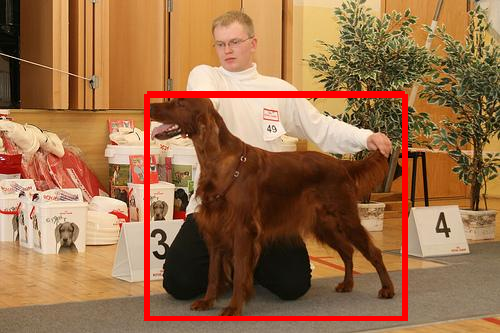

In [16]:
import torch, torchvision
from PIL import Image, ImageDraw
from torchvision.transforms import functional as F
import random, os, json

device = "cuda" if torch.cuda.is_available() else "cpu"

model = torchvision.models.detection.retinanet_resnet50_fpn(
    weights=None,
    num_classes=121
)
model.load_state_dict(torch.load("/content/retinanet_dogs_final.pth", map_location=torch.device('cpu')))
model.eval().to(device)

val=json.load(open("/content/val.json"))
images=val["images"]

# pick random image
sample=random.choice(images)
img_path=os.path.join("/content/dogs/StanfordDogs/Images", sample["file_name"])
img=Image.open(img_path).convert("RGB")

with torch.no_grad():
    out=model([F.to_tensor(img).to(device)])[0]

draw=ImageDraw.Draw(img)
for box,score,label in zip(out["boxes"],out["scores"],out["labels"]):
    if score<0.5: continue
    x1,y1,x2,y2=box.cpu().numpy()
    draw.rectangle([x1,y1,x2,y2], outline="red", width=3)
img

In [17]:
%%writefile eval_coco.py
import argparse, json, torch, torchvision, os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from torchvision.transforms import functional as F

@torch.no_grad()
def run_eval(ann, images_dir, weights, device):
    print("Loading annotations...")
    coco = COCO(ann)
    img_ids = list(coco.imgs.keys())

    print("Loading model...")
    model = torchvision.models.detection.retinanet_resnet50_fpn(
        weights=None,
        num_classes=121
    )
    model.load_state_dict(torch.load(weights, map_location=device))
    model.to(device).eval()

    print("Running inference...")
    results = []

    for img_id in img_ids:
        info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        tensor = F.to_tensor(img).to(device)
        pred = model([tensor])[0]

        # Accept ALL predictions, even low score
        if len(pred["boxes"]) == 0:
            continue

        for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
            x1, y1, x2, y2 = box.tolist()
            results.append({
                "image_id": img_id,
                "category_id": int(label.item()),
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": float(score.item())
            })

    # Save predictions
    with open("predictions.json", "w") as f:
        json.dump(results, f)

    # If no predictions → return zeros
    if len(results) == 0:
        print("\n⚠️ WARNING: No predictions found!")
        print("Your model likely didn't learn enough yet.\n")
        print("Returning zero metrics:")
        print("mAP: 0.0\nAP50: 0.0\nAP75: 0.0\n")
        return

    # Patch COCO file
    if "info" not in coco.dataset:
        coco.dataset["info"] = {}
    if "licenses" not in coco.dataset:
        coco.dataset["licenses"] = []

    print("Running COCO evaluation...")
    coco_dt = coco.loadRes("predictions.json")

    ev = COCOeval(coco, coco_dt, iouType="bbox")
    ev.evaluate()
    ev.accumulate()
    ev.summarize()

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--ann")
    ap.add_argument("--images")
    ap.add_argument("--weights")
    ap.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    args = ap.parse_args()

    run_eval(args.ann, args.images, args.weights, args.device)


Overwriting eval_coco.py


In [18]:
! python eval_coco.py \
  --ann /content/val.json \
  --images /content/dogs/StanfordDogs/Images \
  --weights /content/retinanet_dogs_final.pth

Loading annotations...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model...
Running inference...
Running COCO evaluation...
Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.63s).
Accumulating evaluation results...
DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.872
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.889
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

In [ ]:
!python plot_logs.py \
  --csv /content/logs/train.csv \
  --loss_pdf /content/plots/loss.pdf \
  --loss_components_pdf /content/plots/loss_components.pdf \




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV log
log_path = "/content/logs/train1.csv"   # <-- change this
df = pd.read_csv(log_path)

print(df.head())


           time  epoch  iter      loss  classification  bbox_regression  \
0  1.763394e+09      1     1  2.363186        1.703259         0.659927   
1  1.763394e+09      1     2  2.537604        1.885672         0.651932   
2  1.763394e+09      1     3  2.486760        1.851833         0.634926   
3  1.763394e+09      1     4  2.278682        1.641910         0.636772   
4  1.763394e+09      1     5  2.082831        1.410384         0.672447   

       lr  
0  0.0001  
1  0.0001  
2  0.0001  
3  0.0001  
4  0.0001  


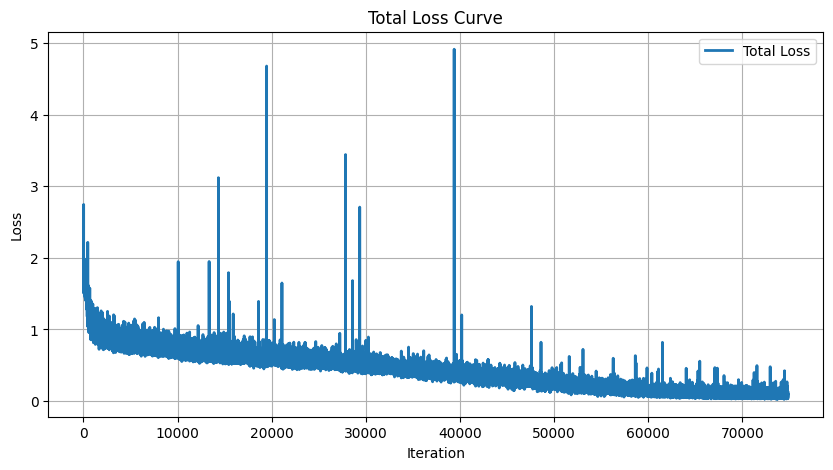

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df["loss"], label="Total Loss", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Total Loss Curve")
plt.grid(True)
plt.legend()
plt.savefig("loss_curve.pdf")
plt.show()


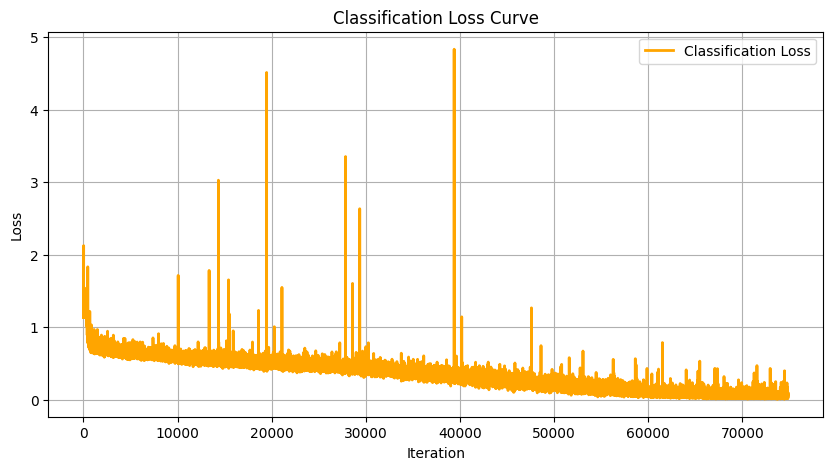

In [ ]:
plt.figure(figsize=(10,5))
plt.plot( df["classification"], label="Classification Loss", linewidth=2, color='orange')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Classification Loss Curve")
plt.grid(True)
plt.legend()
plt.savefig("classification_loss.pdf")
plt.show()


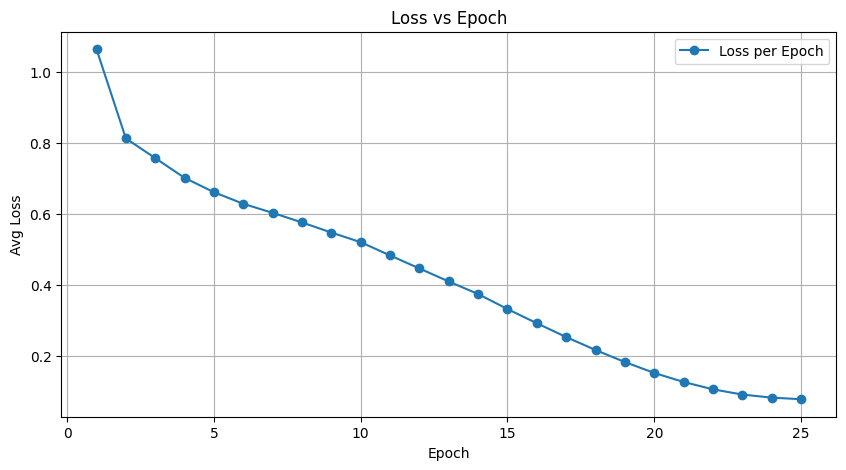

In [ ]:
df_epoch = df.groupby("epoch").mean()

plt.figure(figsize=(10,5))
plt.plot(df_epoch.index, df_epoch["loss"], marker="o", label="Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.savefig("loss_epoch.pdf")
plt.show()


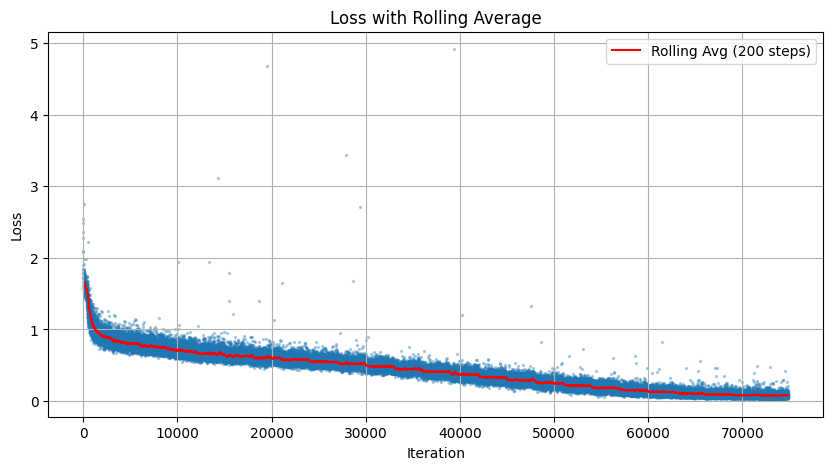

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter((df['epoch']-1) *2994+df["iter"], df["loss"], s=2, alpha=0.3)
plt.plot( df["loss"].rolling(200).mean(), color="red", label="Rolling Avg (200 steps)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss with Rolling Average")
plt.grid(True)
plt.legend()
plt.savefig("loss_rolling.pdf")
plt.show()


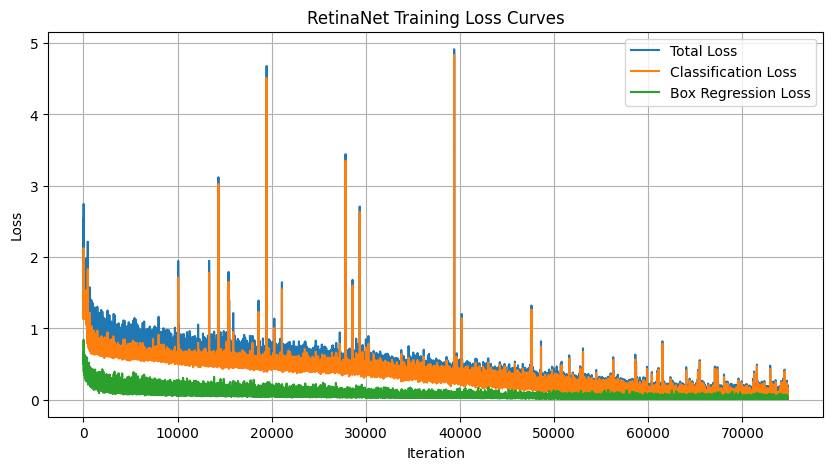

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/logs/train1.csv")

plt.figure(figsize=(10,5))
plt.plot(df["loss"], label="Total Loss")
plt.plot(df["classification"], label="Classification Loss")
plt.plot(df["bbox_regression"], label="Box Regression Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("RetinaNet Training Loss Curves")
plt.legend()
plt.grid()
plt.savefig("loss_curve.pdf")
plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Computing confusion matrix...


100%|██████████| 1996/1996 [00:51<00:00, 39.03it/s]


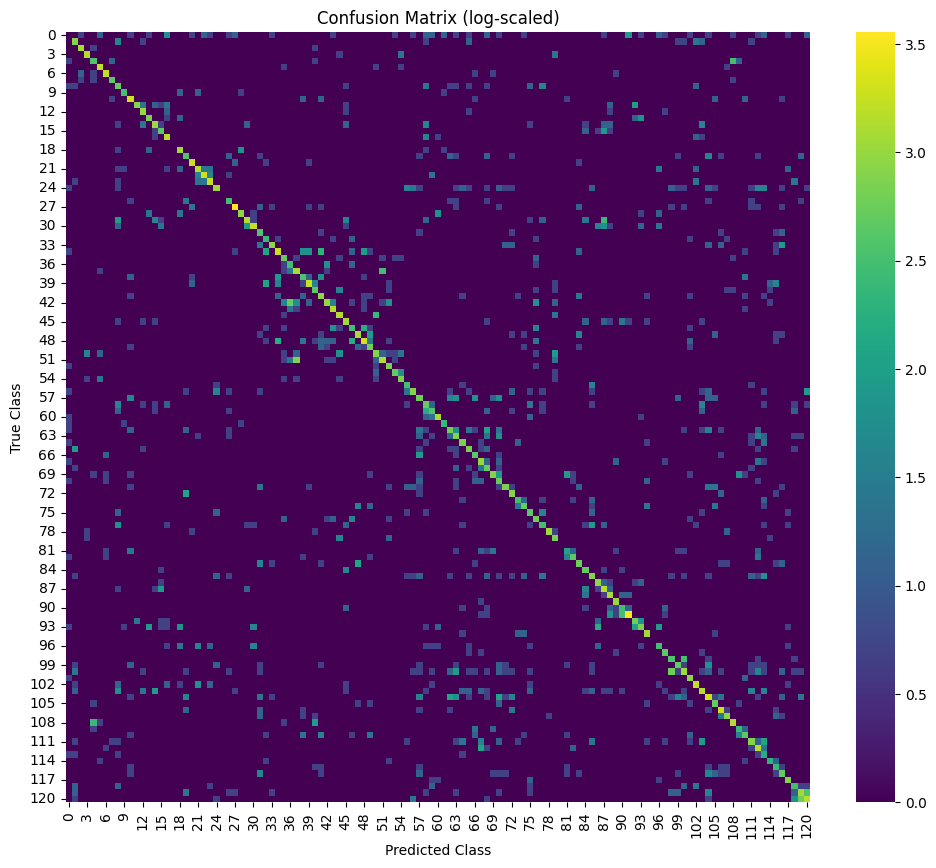

Computing precision–recall curve...


100%|██████████| 1996/1996 [00:49<00:00, 40.65it/s]


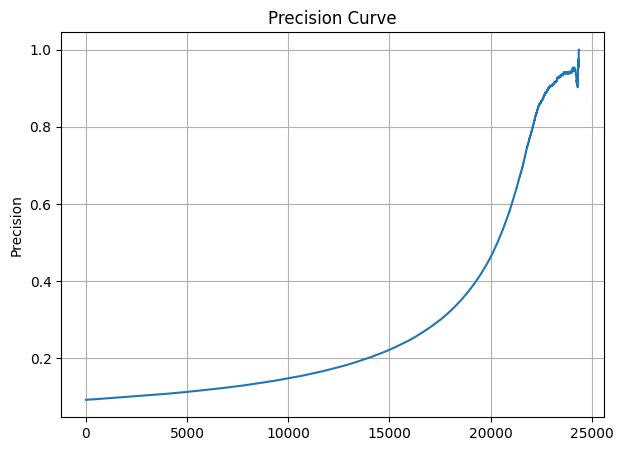

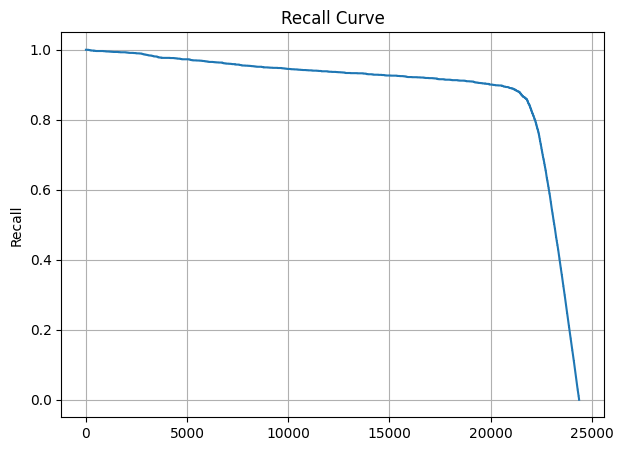

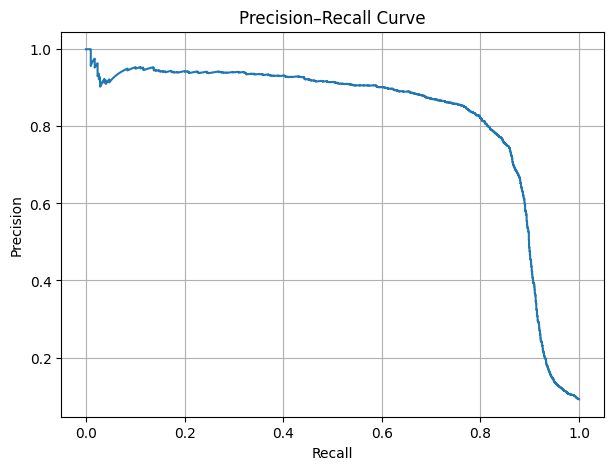

Saved: confusion_matrix.png, precision_recall_curve.png


In [30]:
import torch
import torchvision
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import sys
import os

# Add the current directory to sys.path to allow importing local modules
sys.path.append(os.getcwd())

from dogs_coco_dataset import DogsCocoDet, collate_fn
from pycocotools.coco import COCO
import tqdm

def load_model(weights, num_classes=121, device="cuda"):
    model = torchvision.models.detection.retinanet_resnet50_fpn(
        weights=None,
        weights_backbone=None,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(weights, map_location=device))
    model.to(device)
    model.eval()
    return model

# --------------------------------------------------
# Compute per-class confusion matrix
# --------------------------------------------------
def compute_confusion(model, dataset, device="cuda", iou_thresh=0.5):
    all_gt = []
    all_pred = []
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    for imgs, targets in tqdm.tqdm(loader):
        img = imgs[0].to(device)
        gt_boxes = targets[0]["boxes"].cpu().numpy()
        gt_labels = targets[0]["labels"].cpu().numpy()

        with torch.no_grad():
            pred = model([img])[0]

        pred_boxes = pred["boxes"].cpu().numpy()
        pred_labels = pred["labels"].cpu().numpy()
        scores = pred["scores"].cpu().numpy()

        # Filter weak predictions
        keep = scores > 0.5
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        if len(pred_boxes) == 0:
            # All GT become false negatives
            all_gt.extend(gt_labels)
            all_pred.extend([0]*len(gt_labels))  # 0 = background
            continue

        # IoU matching
        ious = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
        for p_idx in range(len(pred_boxes)):
            max_iou, g_idx = torch.max(ious[p_idx], dim=0)
            if max_iou > iou_thresh:
                all_gt.append(int(gt_labels[g_idx]))
                all_pred.append(int(pred_labels[p_idx]))
            else:
                # False positive
                all_gt.append(0)
                all_pred.append(int(pred_labels[p_idx]))

    # Compute confusion matrix (121 classes incl background)
    cm = confusion_matrix(all_gt, all_pred, labels=list(range(121)))
    return cm

# --------------------------------------------------
# Compute precision–recall curve for the detector
# --------------------------------------------------
def compute_precision_recall(model, dataset, device="cuda"):
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    y_true = []
    y_scores = []

    for imgs, targets in tqdm.tqdm(loader):
        img = imgs[0].to(device)
        gt_labels = targets[0]["labels"].cpu().numpy()

        with torch.no_grad():
            pred = model([img])[0]

        scores = pred["scores"].cpu().numpy()
        labels = pred["labels"].cpu().numpy()

        for s, l in zip(scores, labels):
            y_scores.append(s)
            y_true.append(1 if l in gt_labels else 0)

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return precision, recall, thresholds

# --------------------------------------------------
# Plot utils
# --------------------------------------------------
def plot_confusion(cm, out="confusion_matrix.pdf"):
    import seaborn as sns
    plt.figure(figsize=(12, 10))
    sns.heatmap(np.log1p(cm), cmap="viridis")
    plt.title("Confusion Matrix (log-scaled)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_pr_curve(precision, out="precision_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(precision)
    # plt.xlabel("Precision")
    plt.ylabel("Precision")
    plt.title("Precision Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_re_curve( recall, out="recall_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(recall)
    # plt.xlabel("Recall")
    plt.ylabel("Recall")
    plt.title("Recall Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()

def plot_pre_curve(precision, recall, out="precision_recall_curve.pdf"):
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.grid(True)
    plt.savefig(out, dpi=300)
    plt.show()
    plt.close()


if __name__ == "__main__":
    import argparse
    # Remove the -f argument added by the Jupyter kernel if present
    if "-f" in sys.argv:
        # Find the index of '-f'
        f_index = sys.argv.index("-f")
        # Remove '-f' and its value (the connection file path)
        sys.argv.pop(f_index)
        sys.argv.pop(f_index) # The index is the same after the first pop

    ap = argparse.ArgumentParser()
    ap.add_argument("--images", default="/content/dogs/StanfordDogs/Images")
    ap.add_argument("--ann", default="/content/val.json")
    ap.add_argument("--weights", default="/content/retinanet_dogs_final.pth")
    args = ap.parse_args()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    ds = DogsCocoDet(args.images, args.ann)

    model = load_model(args.weights, device=device)

    print("Computing confusion matrix...")
    cm = compute_confusion(model, ds, device=device)
    np.save("confusion.npy", cm)
    plot_confusion(cm)

    print("Computing precision–recall curve...")
    precision, recall, thresholds = compute_precision_recall(model, ds, device=device)
    plot_pr_curve(precision)
    plot_re_curve(recall)
    plot_pre_curve(precision, recall)

    print("Saved: confusion_matrix.png, precision_recall_curve.png")